In [2]:
!pip install nltk

##Stress, anxiety, and depression are threatening the mental health of people. Every person has a reason for having a stressful life. People often share their feelings on social media platforms like on Instagram in the form of posts and stories, and on Reddit in the form of asking for suggestions about their life on subreddits. In the past few years, many content creators have come forward to create content to help people with their mental health. Many organizations can use stress detection to find which social media users are stressed to help them quickly.

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,KFold,cross_val_score
import nltk
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import files
uploaded=files.upload()

Saving stress.csv to stress.csv


In [6]:
df=pd.read_csv("stress.csv")

In [7]:
df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [8]:
df=df[['text','label']]

In [9]:
df.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [11]:
df.isna().sum()

text     0
label    0
dtype: int64

#Step 1 to convert all the text in lower case

In [12]:
df['text']=df['text'].str.lower()

In [13]:
df.head(2)

,text,label
0,"he said he had not felt that way before, sugge...",1
1,"hey there r/assistance, not sure if this is th...",0


In [15]:
longest_sentence_length = df['text'].str.len().max()
longest_sentence_length


1639

In [16]:
longest_sentence_index = df['text'].str.len().idxmax()
longest_sentence_index


438

In [17]:
longest_sentence = df.loc[longest_sentence_index, 'text']
longest_sentence

"i have a very hard time with trying to find a job, from most places i don't get any feedbacks, but get immediate rejection when i try to apply to other open positions at the same company. interestingly there's a lot of propaganda around how there's a shortage on manpower, while at the same time people having difficulty finding jobs. there are notable instances of similar experiences, political opponents' family members getting fired for no reason, etc. my father did a big disservice to the local fidesz by being a key figure against the prison project (which was going to be built by a company very well known for overpriced projects), my grandfather is a well known tankie (who's so racist he's often accidentally agrees with both fidesz and jobbik), not to mention i had a lot of bullies in secondary school who thought i was severely mentally disabled (long story short: i had some speech issues i've since overcome for the most part, but thanks to the hungarian r-word i got some serious sh

In [19]:
shortest_sentence_index = df['text'].str.len().idxmin()
shortest_sentence_index

295

In [20]:
shortest_sentence_length = df['text'].str.len().min()
shortest_sentence_length

6

In [21]:
shortest_sentence = df.loc[shortest_sentence_index, 'text']
shortest_sentence

'#name?'

#Cleaning the text

In [22]:
stemmer=PorterStemmer()
stop_words=set(stopwords.words('english'))

In [24]:
def clean_text(text):
  words=re.sub('[^a-zA-Z]'," ",text).lower().split()#[^a-zA-Z]: This part defines a pattern that matches any character except lowercase and uppercase letters (a-z and A-Z).
                                                    #" " : This replaces all characters matching the pattern with a space.
  words = [stemmer.stem(word) for word in words if word not in stop_words]
  cleaned_text = ' '.join(words)
  return cleaned_text

In [25]:
#Creating a column of cleaned text with stemming
df['Clean_Stem']=df['text'].apply(clean_text)

In [26]:
df.head(3)

,text,label,Clean_Stem
0,"he said he had not felt that way before, sugge...",1,said felt way sugget go rest trigger ahead you...
1,"hey there r/assistance, not sure if this is th...",0,hey r assist sure right place post goe current...
2,my mom then hit me with the newspaper and it s...,1,mom hit newspap shock would know like play hit...


In [27]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
def lemmatize_text(text):
    words = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [30]:
df['Clean_Lamit']=df['text'].apply(lemmatize_text)

In [31]:
df.head()

,text,label,Clean_Stem,Clean_Lamit
0,"he said he had not felt that way before, sugge...",1,said felt way sugget go rest trigger ahead you...,said felt way suggeted go rest trigger ahead y...
1,"hey there r/assistance, not sure if this is th...",0,hey r assist sure right place post goe current...,hey r assistance sure right place post go curr...
2,my mom then hit me with the newspaper and it s...,1,mom hit newspap shock would know like play hit...,mom hit newspaper shocked would know like play...
3,"until i met my new boyfriend, he is amazing, h...",1,met new boyfriend amaz kind sweet good student...,met new boyfriend amazing kind sweet good stud...
4,october is domestic violence awareness month a...,1,octob domest violenc awar month domest violenc...,october domestic violence awareness month dome...


In [35]:
print(df.iloc[2])

text           my mom then hit me with the newspaper and it s...
label                                                          1
Clean_Stem     mom hit newspap shock would know like play hit...
Clean_Lamit    mom hit newspaper shocked would know like play...
Name: 2, dtype: object


#Now let’s have a look at the most used words by the people sharing about their life problems on social media by visualizing a word cloud of the text column

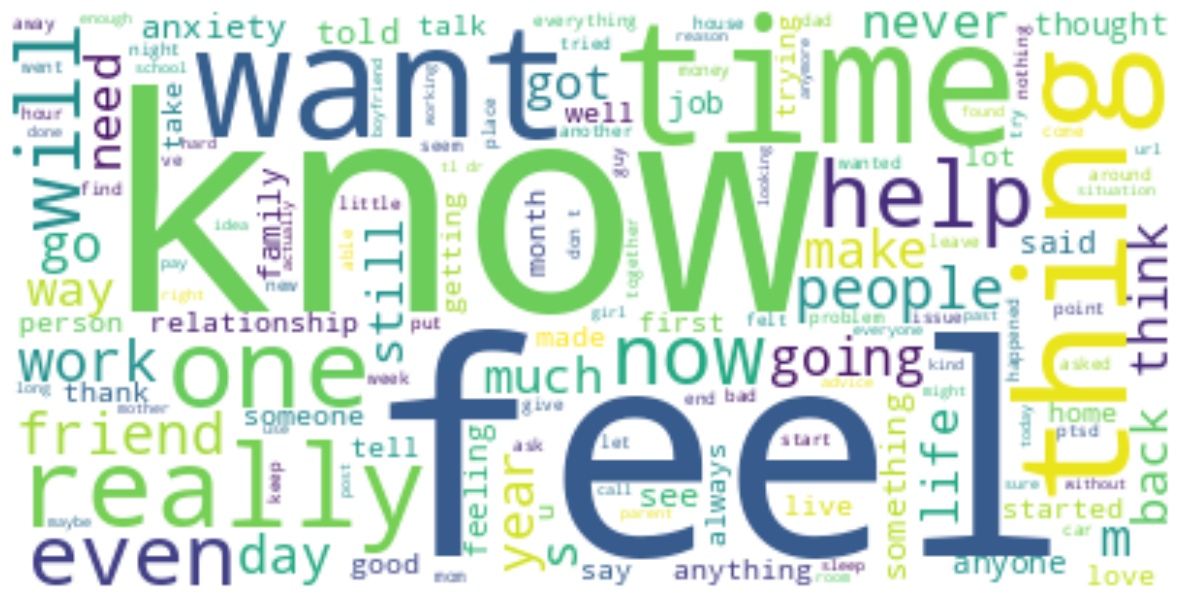

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
def tokenize_text(text):
        return word_tokenize(text)

In [38]:
df['Tokenized_Clean_lamit'] = df['Clean_Lamit'].apply(tokenize_text)

In [39]:
df.head(2)

,text,label,Clean_Stem,Clean_Lamit,Tokenized_Clean_lamit
0,"he said he had not felt that way before, sugge...",1,said felt way sugget go rest trigger ahead you...,said felt way suggeted go rest trigger ahead y...,"[said, felt, way, suggeted, go, rest, trigger,..."
1,"hey there r/assistance, not sure if this is th...",0,hey r assist sure right place post goe current...,hey r assistance sure right place post go curr...,"[hey, r, assistance, sure, right, place, post,..."


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
x = cv.fit_transform(df['Clean_Lamit']).toarray()

In [43]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [45]:
y=df['label']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [47]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

In [48]:
y_pred=spam_detect_model.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score,classification_report

In [51]:
score=accuracy_score(y_test,y_pred)
print(score)

0.7429577464788732


In [52]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = spam_detect_model.predict(data)
print(output)

Enter a Text: what the hell
[1]


In [53]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = spam_detect_model.predict(data)
print(output)

Enter a Text: Ananya Panday attended the star-studded Prime Video event in Mumbai, where the streaming platform announced several new and returning series and original and licensed films. Ananya's new project, Call Me Bae, was also announced at the affair. For the occasion, Ananya turned into a muse for designer Rahul Mishra, with whom she has collaborated in the past to serve magical sartorial moments (remember her debut at Paris Haute Couture Week). Scroll through to see what Ananya wore.
[0]
